# exp013_ea
exp013のエラー解析

In [127]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import optuna
import pyproj
from pyproj import Proj, transform

pd.set_option('display.max_rows', 100)

In [128]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [129]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

In [130]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [131]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [132]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [172]:
class train_result:
    def __init__(self, df, gt):
        self.df = df
        self.gt = gt
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)
        return tmp

In [173]:
train = pd.read_csv('../output/exp013/train_ps.csv') 
test = pd.read_csv('../output/exp013/exp013.csv')
train['phone'] = train['collectionName'] + '_' + train['phoneName']

In [174]:
# ground_truth
p = pathlib.Path(INPUT)
gt_files = list(p.glob('train/*/*/ground_truth.csv'))
print('ground_truth.csv count : ', len(gt_files))

gts = []
for gt_file in tqdm(gt_files):
    gts.append(pd.read_csv(gt_file))
ground_truth = pd.concat(gts)

display(ground_truth.head())

ground_truth.csv count :  73


  0%|          | 0/73 [00:00<?, ?it/s]

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree
0,2020-05-21-US-MTV-2,Pixel4,1274131364434,37.628927,-122.426295,65.36,64.43,2.6,0.0,0.0,154.3
1,2020-05-21-US-MTV-2,Pixel4,1274131365434,37.628927,-122.426295,65.36,65.43,2.6,0.0,0.0,154.3
2,2020-05-21-US-MTV-2,Pixel4,1274131366434,37.628927,-122.426295,65.36,66.43,2.6,0.0,0.0,154.3
3,2020-05-21-US-MTV-2,Pixel4,1274131367434,37.628927,-122.426295,65.36,67.43,2.6,0.0,0.0,154.3
4,2020-05-21-US-MTV-2,Pixel4,1274131368434,37.628927,-122.426295,65.36,68.43,2.6,0.0,0.0,154.3


In [175]:
tmp = result.raw_data
tmp[tmp['collectionName']=='2021-04-22-US-SJC-1']

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,phone,heightAboveWgs84EllipsoidM_x,x,y,z,...,znew,latDeg_gt,lngDeg_gt,heightAboveWgs84EllipsoidM_y,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree,err
103937,2021-04-22-US-SJC-1,Pixel4,1303160575446,37.334548,-121.899320,2021-04-22-US-SJC-1_Pixel4,63.5,-2.683154e+06,-4.310781e+06,3.847018e+06,...,NaN,37.334581,-121.899447,56.91,325.45,1.8,0.0,0.0,330.5,11.816707
103938,2021-04-22-US-SJC-1,Pixel4,1303160576446,37.334561,-121.899363,2021-04-22-US-SJC-1_Pixel4,63.5,-2.683157e+06,-4.310778e+06,3.847020e+06,...,3.847019e+06,37.334581,-121.899447,56.91,326.45,1.8,0.0,0.0,330.5,7.783143
103939,2021-04-22-US-SJC-1,Pixel4,1303160577446,37.334563,-121.899368,2021-04-22-US-SJC-1_Pixel4,63.5,-2.683157e+06,-4.310778e+06,3.847020e+06,...,3.847020e+06,37.334581,-121.899447,56.91,327.45,1.8,0.0,0.0,330.5,7.235453
103940,2021-04-22-US-SJC-1,Pixel4,1303160578446,37.334573,-121.899391,2021-04-22-US-SJC-1_Pixel4,63.5,-2.683159e+06,-4.310776e+06,3.847021e+06,...,3.847021e+06,37.334581,-121.899447,56.91,328.45,1.8,0.0,0.0,330.5,4.975770
103941,2021-04-22-US-SJC-1,Pixel4,1303160579446,37.334577,-121.899404,2021-04-22-US-SJC-1_Pixel4,63.5,-2.683160e+06,-4.310775e+06,3.847021e+06,...,3.847021e+06,37.334581,-121.899447,56.91,329.45,1.8,0.0,0.0,330.5,3.798012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109648,2021-04-22-US-SJC-1,SamsungS20Ultra,1303163398000,37.334614,-121.899395,2021-04-22-US-SJC-1_SamsungS20Ultra,63.5,-2.683158e+06,-4.310774e+06,3.847024e+06,...,3.847024e+06,37.334600,-121.899424,59.13,3148.00,2.9,0.0,0.0,329.4,2.970781
109649,2021-04-22-US-SJC-1,SamsungS20Ultra,1303163399000,37.334614,-121.899396,2021-04-22-US-SJC-1_SamsungS20Ultra,63.5,-2.683158e+06,-4.310774e+06,3.847024e+06,...,3.847024e+06,37.334600,-121.899424,59.13,3149.00,2.9,0.0,0.0,329.4,2.912900
109650,2021-04-22-US-SJC-1,SamsungS20Ultra,1303163400000,37.334616,-121.899398,2021-04-22-US-SJC-1_SamsungS20Ultra,63.5,-2.683158e+06,-4.310774e+06,3.847024e+06,...,3.847024e+06,37.334600,-121.899424,59.13,3150.00,2.9,0.0,0.0,329.4,2.909244
109651,2021-04-22-US-SJC-1,SamsungS20Ultra,1303163401000,37.334617,-121.899401,2021-04-22-US-SJC-1_SamsungS20Ultra,63.5,-2.683158e+06,-4.310774e+06,3.847024e+06,...,3.847024e+06,37.334600,-121.899424,59.13,3151.00,2.9,0.0,0.0,329.4,2.745404


In [176]:
result = train_result(train, ground_truth)

In [177]:
result.err

,percentile50,percentile95,p50_p90_mean
phone,,,
2020-05-14-US-MTV-1_Pixel4,1.190093,2.370496,1.780295
2020-05-14-US-MTV-1_Pixel4XLModded,1.080405,2.249242,1.664823
2020-05-14-US-MTV-2_Pixel4,1.643581,3.151935,2.397758
2020-05-14-US-MTV-2_Pixel4XLModded,1.749689,4.568295,3.158992
2020-05-21-US-MTV-1_Pixel4,1.786363,3.361521,2.573942
2020-05-21-US-MTV-2_Pixel4,0.630239,2.343165,1.486702
2020-05-21-US-MTV-2_Pixel4XL,0.583440,2.155346,1.369393
2020-05-29-US-MTV-1_Pixel4,2.120376,3.476001,2.798189
2020-05-29-US-MTV-1_Pixel4XL,1.894211,3.193818,2.544014


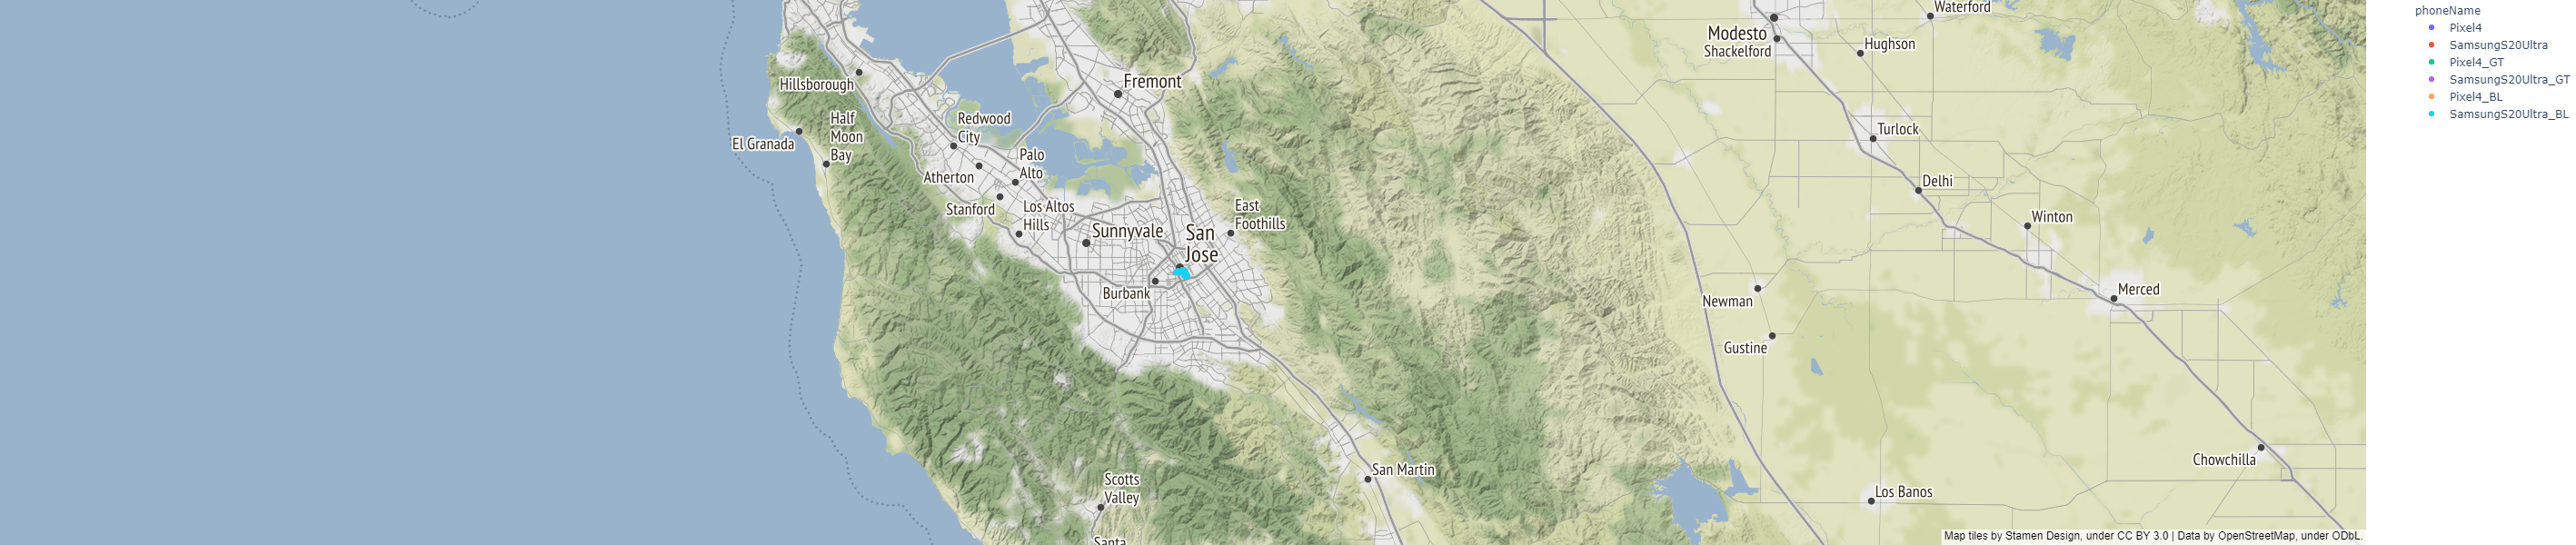

,collectionName,phoneName,latDeg,lngDeg
117688,2021-04-28-US-SJC-1,Pixel4,37.334120,-121.900178
117689,2021-04-28-US-SJC-1,Pixel4,37.334132,-121.900216
117690,2021-04-28-US-SJC-1,Pixel4,37.334139,-121.900240
117691,2021-04-28-US-SJC-1,Pixel4,37.334143,-121.900251
117692,2021-04-28-US-SJC-1,Pixel4,37.334144,-121.900255
...,...,...,...,...
121780,2021-04-28-US-SJC-1,SamsungS20Ultra_BL,37.334145,-121.900141
121781,2021-04-28-US-SJC-1,SamsungS20Ultra_BL,37.334144,-121.900160
121782,2021-04-28-US-SJC-1,SamsungS20Ultra_BL,37.334129,-121.900189
121783,2021-04-28-US-SJC-1,SamsungS20Ultra_BL,37.334116,-121.900210


In [178]:
result.viz_map('2021-04-28-US-SJC-1')

In [125]:
result.phone_err

,percentile50,percentile95,p50_p90_mean
phone,,,
2020-05-14-US-MTV-1_Pixel4,1.190093,2.370496,1.780295
2020-05-14-US-MTV-1_Pixel4XLModded,1.080405,2.249242,1.664823
2020-05-14-US-MTV-2_Pixel4,1.643581,3.151935,2.397758
2020-05-14-US-MTV-2_Pixel4XLModded,1.749689,4.568295,3.158992
2020-05-21-US-MTV-1_Pixel4,1.786363,3.361521,2.573942
2020-05-21-US-MTV-2_Pixel4,0.630239,2.343165,1.486702
2020-05-21-US-MTV-2_Pixel4XL,0.583440,2.155346,1.369393
2020-05-29-US-MTV-1_Pixel4,2.120376,3.476001,2.798189
2020-05-29-US-MTV-1_Pixel4XL,1.894211,3.193818,2.544014
